In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/flickr8k/Images/2925242998_9e0db9b4a2.jpg
/kaggle/input/flickr8k/Images/2969380952_9f1eb7f93b.jpg
/kaggle/input/flickr8k/Images/444845904_a4531c811a.jpg
/kaggle/input/flickr8k/Images/3355827928_c96c0c3e88.jpg
/kaggle/input/flickr8k/Images/3150440350_b0f2a9e774.jpg
/kaggle/input/flickr8k/Images/3613705104_46d854134e.jpg
/kaggle/input/flickr8k/Images/3712742641_641282803e.jpg
/kaggle/input/flickr8k/Images/2922512807_d382528a93.jpg
/kaggle/input/flickr8k/Images/3323952123_deb50b0629.jpg
/kaggle/input/flickr8k/Images/3144705706_391d7b77c7.jpg
/kaggle/input/flickr8k/Images/3590653633_495de5f288.jpg
/kaggle/input/flickr8k/Images/421730441_6b2267fd31.jpg
/kaggle/input/flickr8k/Images/3647170476_0fd71a4c9f.jpg
/kaggle/input/flickr8k/Images/2432061076_0955d52854.jpg
/kaggle/input/flickr8k/Images/1798215547_ef7ad95be8.jpg
/kaggle/input/flickr8k/Images/1262077938_8b9516c273.jpg
/kaggle/input/flickr8k/Images/3480379024_545e8ec818.jpg

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# VGG16 : helps to extarct both complex and simple features from images

In [4]:
# pretrained model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [6]:
BASE_DIR = "/kaggle/input/flickr8k/"
OUTPUT_DIR = '/kaggle/working'

In [7]:
features = {}
INPUT_DIR = '/tmp'  # This is not used currently

BASE_DIR = '/kaggle/input/flickr8k/Images'  # Make sure this is correctly set
directory = BASE_DIR  # Instead of adding 'Images' again

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

Stroing the image features in pickle

In [11]:
import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [12]:
pickle.dump(features, open(os.path.join(OUTPUT_DIR, 'features.pkl'), 'wb'))

In [13]:
pickle_file_path = os.path.join(OUTPUT_DIR, 'features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# Caption Data

In [15]:
with open(os.path.join("/kaggle/input/flickr8k/", 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [16]:
mapping = {}

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption using defaultdict
    mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


# 40455 captions for 8091 images : 5 captions for wach image

# Preprocessing Captions

In [17]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [18]:
mapping['1003163366_44323f5815']

['A man lays on a bench while his dog sits by him .',
 'A man lays on the bench to which a white dog is also tied .',
 'a man sleeping on a bench outside with a white and black dog sitting next to him .',
 'A shirtless man lies on a park bench with his dog .',
 'man laying on bench holding leash of dog sitting on ground']

In [19]:
mapping['101669240_b2d3e7f17b']

['A man in a hat is displaying pictures next to a skier in a blue hat .',
 'A man skis past another man displaying paintings in the snow .',
 'A person wearing skis looking at framed pictures set up in the snow .',
 'A skier looks at framed pictures in the snow next to trees .',
 'Man on skis looking at artwork for sale in the snow']

In [20]:
clean(mapping)

In [21]:
# after preprocessing
mapping['101669240_b2d3e7f17b']

['startseq man in hat is displaying pictures next to skier in blue hat endseq',
 'startseq man skis past another man displaying paintings in the snow endseq',
 'startseq person wearing skis looking at framed pictures set up in the snow endseq',
 'startseq skier looks at framed pictures in the snow next to trees endseq',
 'startseq man on skis looking at artwork for sale in the snow endseq']

In [22]:
# Creating a List of All Captions
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [23]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [25]:
# SAVE
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# LOAD
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [26]:
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

max_caption_length

34

# Train Test Split

In [27]:
# Creating a List of Image IDs
image_ids = list(mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [28]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# LSTM Model Training


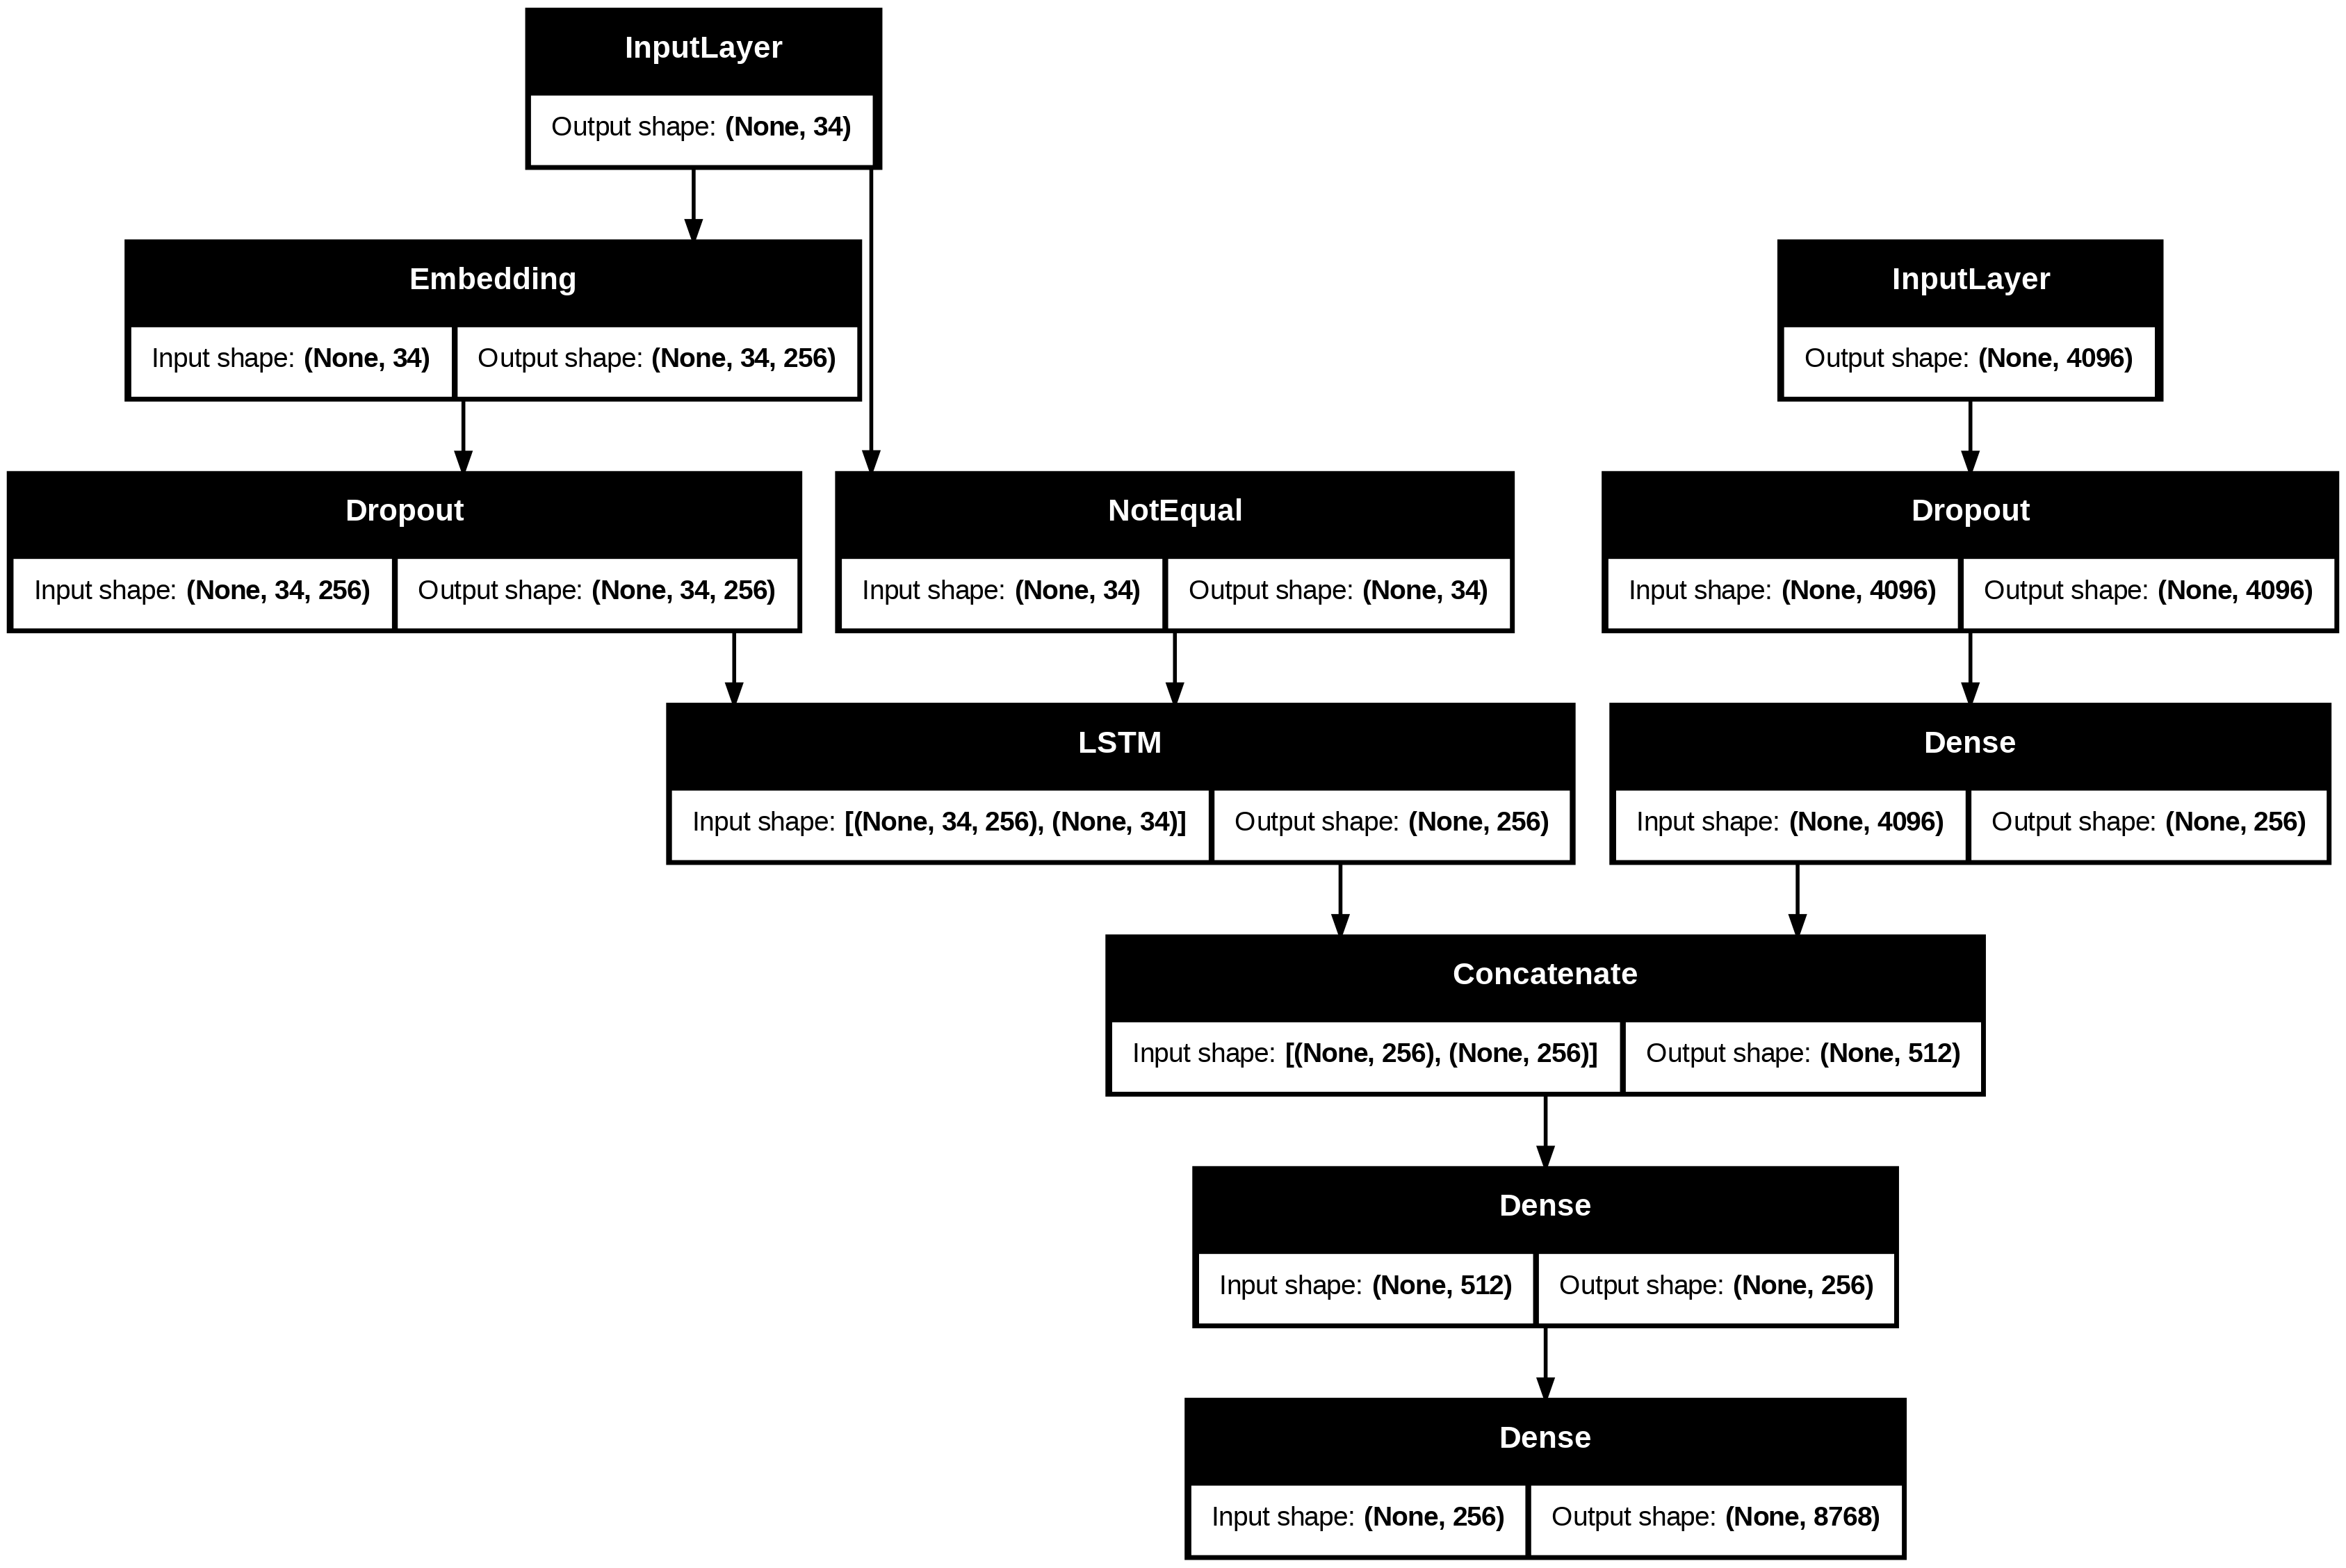

In [29]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_caption_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [30]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_caption_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 326ms/step - loss: 5.7290
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 4.0453
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 302ms/step - loss: 3.5771
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 299ms/step - loss: 3.2878
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - loss: 3.0764
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - loss: 2.9181
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 300ms/step - loss: 2.7995
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 299ms/step - loss: 2.6983
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 309ms/step - loss: 2.6107
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 2.5376
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 304ms/step - loss: 2.4742
227/227 ━━━━━━━━━━━━━━━━━━━━ 72s 316ms/step - loss: 2.4138
227/227 ━━━━━━━━━━━━━━━━━━━━ 74s 324ms/step - loss: 2.3598
227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 346ms/step - loss: 2.3084
227/227 ━━━━━━━━━━━━━━━━━━━━ 85s 374ms/step - loss: 2.2584


# GENERATING CAPTIONS FOR THE IMAGE


In [31]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [32]:
# generate caption for image

def predict_caption(model,image,tokenizer,max_len):
    in_text='<startseq>'
    for i in range(max_len):
        seq=tokenizer.texts_to_sequences([in_text])[0]
        seq=pad_sequences([seq],max_caption_length,padding='post')
        y_pred=model.predict([image,seq],verbose=0) # will give the probabbility distribution across all words of vocabulary
        pred_index=np.argmax(y_pred)
        pred_word=get_word_from_index(pred_index,tokenizer)
        if pred_word==None:
            break
        in_text+=' '+pred_word
        if pred_word=='<endseq>':
            break
    return in_text

In [34]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_caption_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.147090
BLEU-2: 0.081413


# Predicting the captions

In [39]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
<startseq> three dogs are playing in grassy field endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


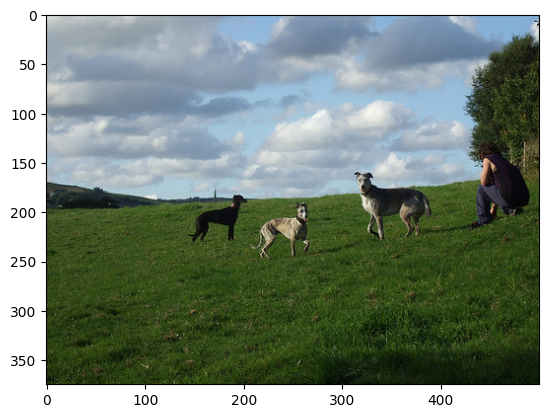

In [42]:
generate_caption("1032122270_ea6f0beedb.jpg")

---------------------Actual---------------------
startseq woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snowcovered mountain endseq
startseq woman in blue jacket rides brown pony near water endseq
startseq woman rides horse near frozen lake in the wintertime endseq
startseq young blond woman sitting atop brown draft horse in the snowy mountains endseq
startseq woman blue jacket sits on daft horse near frozen lake endseq
--------------------Predicted--------------------
<startseq> two dogs are standing in the snow endseq on the wintertime endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


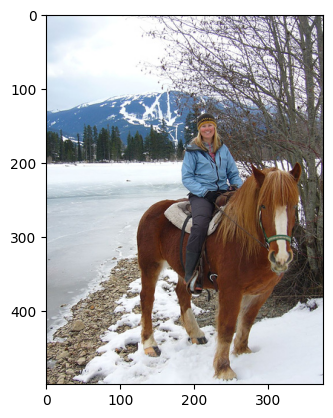

In [43]:
generate_caption("109202756_b97fcdc62c.jpg")

---------------------Actual---------------------
startseq black dog jumping to catch rope toy endseq
startseq black dog playing fetch with ball of rope endseq
startseq black dog pounces to get rope toy endseq
startseq black dog running after his rope toy endseq
startseq large black dog is playing in grassy yard endseq
--------------------Predicted--------------------
<startseq> black dog is jumping over fallen toy endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


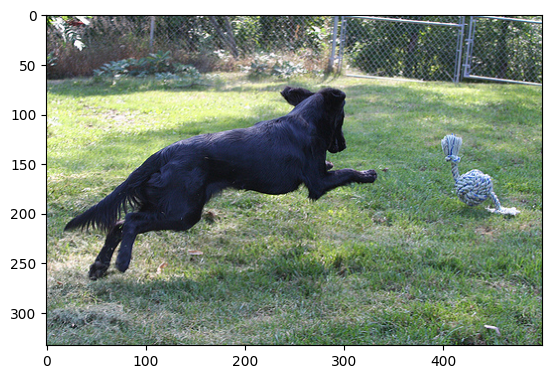

In [44]:
generate_caption("1107246521_d16a476380.jpg")